### 작업 1
- LG 요청 사항 (언리얼 시각화요청)
- 장애물 있는 데이터 UX,UY,UZ,속도값 이 포함된 데이터프레임 필요 (윤영이한테 전달)

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.contrib import tzip
from scipy.interpolate import griddata

from src.utils.preprocess import *
from src.utils.config import *
from src.models.model import *
from src.utils.util import *
# from src.utils.generate_output import *
from src.utils.generate_boundary_condition import *

c:\Users\chang\Anaconda3\envs\CFD\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
no_obstacle_data,yes_obstacle_data = load_data()

In [4]:
obstacle_value_lst=np.load(open("./src/data/obstacle_value_lst.npy",'rb'))

In [6]:
# 사용할 번호 (둘다 존재 : , 테이블만 존재 : 60)
use_num = 4
inlist = [0.3798,0.4548,0,0.466,2.7,2.7] # 현재는 입구/출구 위치동일하기에 단순히 리스트로 정의하여사용
outlist = [0.044,0.1898,0,0.466,2.7,2.7]

# 데이터 로드
output_data = {}
dimension_setting = [120,60,64]

for option in ["ux","uy","uz","velocity"]:
        for i,j in tzip(yes_obstacle_data[use_num:use_num+1],obstacle_value_lst[use_num:use_num+1]):
                j = j.reshape(dimension_setting[0],dimension_setting[1],dimension_setting[2])
                with open("dataset/raw/yes_obstacle/"+i,"r") as txt_file:
                        df = text_to_df(txt_file)
                aligned_df = manipulate_dataframe(0,df,dimension_setting,option)
                aligned_df = make_bdr(aligned_df,inlist,outlist)
                value = aligned_df[option].values.reshape(dimension_setting[0],dimension_setting[1],dimension_setting[2])    
                value = value*j
                output_data[option]=value

100%|██████████| 1/1 [00:06<00:00,  6.36s/it]


In [9]:
aligned_df["ux"] = output_data["ux"].reshape(120*60*64)
aligned_df["uy"] = output_data["uy"].reshape(120*60*64)
aligned_df["uz"] = output_data["uz"].reshape(120*60*64)
aligned_df["velocity"] = output_data["velocity"].reshape(120*60*64)
aligned_df["obs"] = j.reshape(120*60*64)

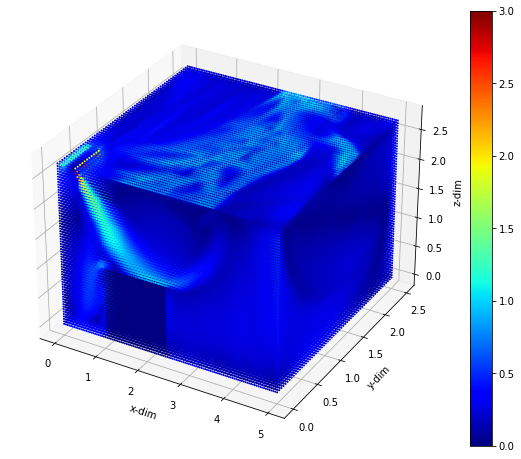

In [10]:
plotting(aligned_df,aligned_df["velocity"],[10,8,1,1,0,3,30,300])

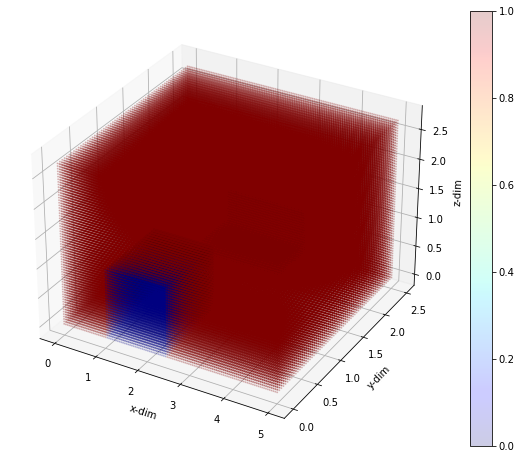

In [11]:
plotting(aligned_df,aligned_df["obs"],[10,8,1,0.2,0,1,30,300])

In [14]:
aligned_df["obs_total"] = aligned_df["obs"]*aligned_df["Boundary"]
aligned_df

,x,y,z,velocity,Boundary,ux,uy,uz,obs,obs_total
0,0.0,0.0,0.000000,0.224053,2,-0.132396,0.015032,0.180125,1.0,2.0
1,0.0,0.0,0.042857,0.179610,2,-0.124803,0.027348,0.126238,1.0,2.0
2,0.0,0.0,0.085714,0.221019,2,-0.107780,0.033255,0.190071,1.0,2.0
3,0.0,0.0,0.128571,0.269188,2,-0.092102,0.033040,0.250775,1.0,2.0
4,0.0,0.0,0.171429,0.301656,2,-0.077718,0.030473,0.289875,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
460795,5.0,2.5,2.528571,0.430509,2,-0.007024,-0.004872,0.430425,1.0,2.0
460796,5.0,2.5,2.571429,0.403808,2,-0.011604,-0.008669,0.403548,1.0,2.0
460797,5.0,2.5,2.614286,0.356809,2,-0.019709,-0.016136,0.355898,1.0,2.0
460798,5.0,2.5,2.657143,0.268928,2,-0.035203,-0.031763,0.264715,1.0,2.0


### x축 대칭 (y값 변경) + 결합

In [15]:
aligned_df_reverse = aligned_df.copy()
aligned_df_reverse["y"] = aligned_df["y"]*-1
aligned_df_reverse["uy"] = aligned_df["uy"]*-1
aligned_df_reverse = aligned_df_reverse.sort_values("y").reset_index(drop=True)

1. reverse df에서 y=-0.0 제거
2. 기존 df에서 y=0.0일때 uy속도값 0으로 수정
3. 결합

In [16]:
drop_idx = aligned_df_reverse[aligned_df_reverse["y"]==-0.0].index
aligned_df_reverse.drop(drop_idx,inplace=True)
aligned_df.loc[aligned_df["y"]==0.0,"uy"]=0.000000
df = pd.concat([aligned_df_reverse,aligned_df],axis=0)
df = df.reset_index(drop=True)

# 정렬순서변경 (z증가 x증가 y증가 ==  y,x,z 로 지정)
# y,x 일정하면 z증가 --> y일정하면 x증가 
# df = df.sort_values(by=["y","x","z"]).reset_index(drop=True)
df = df.sort_values(by=["z","x"]).reset_index(drop=True)
df

,x,y,z,velocity,Boundary,ux,uy,uz,obs,obs_total
0,0.0,-2.500000,0.0,0.257852,2,-0.051112,-0.041929,0.249233,1.0,2.0
1,0.0,-2.457627,0.0,0.229751,2,-0.040595,-0.083205,0.210272,1.0,2.0
2,0.0,-2.415254,0.0,0.220914,2,-0.038947,-0.125488,0.177592,1.0,2.0
3,0.0,-2.372881,0.0,0.229914,2,-0.038454,-0.158826,0.161728,1.0,2.0
4,0.0,-2.330508,0.0,0.246006,2,-0.038927,-0.189991,0.151351,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
913915,5.0,2.330508,2.7,0.226753,2,-0.059234,-0.174007,0.132779,1.0,2.0
913916,5.0,2.372881,2.7,0.238351,2,-0.060613,-0.178008,0.146460,1.0,2.0
913917,5.0,2.415254,2.7,0.243553,2,-0.061719,-0.165311,0.167873,1.0,2.0
913918,5.0,2.457627,2.7,0.244864,2,-0.061721,-0.124777,0.201444,1.0,2.0


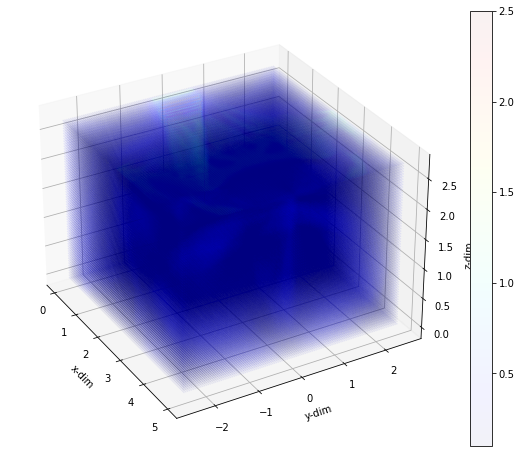

In [88]:
plotting(df,df["velocity"],[10,8,0.5,0.05,0.1,2.5,30,330])

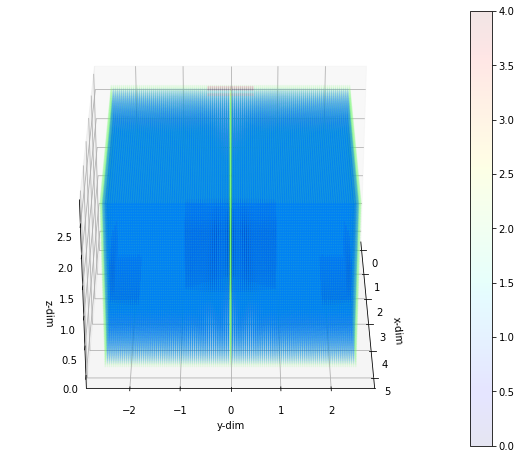

In [73]:
plotting(df,df["obs_total"],[10,8,0.5,0.1,0,4,30,360])

In [94]:
def test_plotting(df,plot_value,setting_lst):
    '''360도 돌면서 이미지저장위해 작성한 코드'''
    # setting_lst : [plot크기(가로),plot크기(세로),값 세기,투명도,최소값,최대값,앵글각도(고도),앵글각도(방위)]
    x = np.asarray(df['x'])
    y = np.asarray(df['y'])
    z = np.asarray(df['z'])
    # plt.colorbar(im)
    ran = np.arange(0,370,10)
    for idx,i in enumerate(ran):
        fig = plt.figure(figsize=(setting_lst[0],setting_lst[1]))
        ax = plt.axes(projection="3d")
        im = ax.scatter3D(x,y,z,zdir='z', c=plot_value, cmap='jet',s=setting_lst[2], alpha=setting_lst[3], vmin=setting_lst[4], vmax=setting_lst[5])
        ax.view_init(setting_lst[6],i)
        ax.set_xlabel("x-dim")
        ax.set_ylabel("y-dim")
        ax.set_zlabel("z-dim")
        plt.savefig(f"image_data/{idx}.png")
        plt.clf()

In [95]:
test_plotting(df,df["velocity"],[10,8,0.5,0.05,0.1,2.5,30,330])

c:\Users\chang\Anaconda3\envs\CFD\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

최종 PyVista 확인

In [90]:
# opt_list=[1,4,5,0.5,1,4.5]
# xx = df["x"].values
# yy = df["y"].values
# zz = df["z"].values
# pyvista_plot(df["obs_total"],opt_list,[xx,yy,zz])

In [92]:
opt_list=[0.2,2,5,0.5,0,3]
xx = df["x"].values
yy = df["y"].values
zz = df["z"].values
pyvista_plot(df["velocity"],opt_list,[xx,yy,zz])

저장

In [13]:
np.save("1way3d_dp304.npy",df)